In [1]:
%matplotlib inline
import csv, random
from numpy import genfromtxt
import sys
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import GPy
from sklearn.model_selection import train_test_split

/Applications/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [2]:
#Import dataset to the appropriate structure
import pandas as pd
data = pd.read_csv("istanbul_stock_exchange.csv")
df1 = data.iloc[2:] 
Original_dataset = df1.drop(df1.columns[0], axis=1)
df3 = Original_dataset.drop(Original_dataset.columns[0:2], axis = 1)
X = df3.values.astype(np.float)
df5 = Original_dataset.drop(Original_dataset.columns[1:], axis = 1)
y = df5.values.astype(np.float)

In [3]:
#Normalise 
mean_y = y.mean()
y_norm = y-mean_y

In [4]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.2, random_state=42)

In [5]:
#Model Fitting function
def init_full():
    kern = gpflow.kernels.RBF(X_train.shape[1],1)
    from scipy.cluster.vq import kmeans
    m_gp = gpflow.models.VGP(X_train, y_train, kern, gpflow.likelihoods.Gaussian())
    return m_gp

In [14]:
X_train.shape[1]

7

In [6]:
#Model Fit
m = init_full()

In [7]:
#Logger to save for plotting
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            self.logf.append(likelihood)

In [8]:
#Define and perform optimization algorithm
def run_opt (model, iterations,var_list=None):
    if var_list is None:
        var_list = [(model.q_mu, model.q_sqrt)]
    model.q_mu.set_trainable(False)
    model.q_sqrt.set_trainable(False)
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    model.q_mu.set_trainable(True)
    model.q_sqrt.set_trainable(True)
    natgrad=gpflow.training.NatGradOptimizer(1).make_optimize_action(model,var_list = var_list)
    logger = Logger(model)
    actions = [adam,natgrad,logger]
    loop = gpflow.actions.Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())
    return logger

logger1 = run_opt(m, gpflow.test_util.notebook_niter(20000), var_list=[(m.q_mu, m.q_sqrt)])

Text(0,0.5,'ELBO')

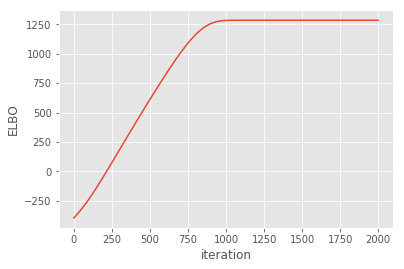

In [9]:
#Plotting the learning process
plt.plot(-np.array(logger1.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO')

In [10]:
#Show parameters after optimization
logger1.model.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/variance,Parameter,None,+ve,True,(),True,0.0043847641441770654
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,0.27627362042481657
VGP/likelihood/variance,Parameter,None,+ve,True,(),True,0.00013344487134323035
VGP/q_mu,Parameter,None,(none),True,"(428, 1)",True,"[[0.0121455012591], [0.112689145772], [0.82418..."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 428, 428)",True,"[[[0.0270060201141, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


In [20]:
#RMSE calculation
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test,m.predict_y(X_test)[0]))
rmse/(m.predict_y(X_test)[0].max()-m.predict_y(X_test)[0].min())

0.19525346882147659

In [12]:
m.compute_log_likelihood()

1285.2703448125765

In [23]:
#mean Negative log probability density
-m.predict_density(X_test,m.predict_y(X_test)[0]).mean()

-3.527308816628338

In [26]:
#standard deviation of nlpd
np.std(m.predict_density(X_test,m.predict_y(X_test)[0]))

0.019671461237547417

In [ ]:
#However, that is taken an hour to optimize cuz of the cost of computation